In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
from tqdm import tqdm
import pickle
from sklearn.preprocessing import MinMaxScaler

In [2]:
seed = 1
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [3]:
# data prep
def gaussian_noise():
    return np.random.normal()


def ar_data_generator(init_seq, weights, noise_func, steps=500, normalize=False):
    """Generate AR(n) simulation data.

    Args:
        init_seq (np.array): Initial values to start with. An AR(n) process should have n initial values.
        weights (np.array): Weights on each prev time step and the noise term.
        noise_func (func): Calling this noise function gives a random term.
        steps (int): Length of the generated sequence.
    """
    init_steps = len(init_seq)
    sim_data = np.zeros(steps + init_steps)
    sim_data[:init_steps] = init_seq
    for i in range(steps):
        cur_val = 0
        for j in range(init_steps):
            cur_val += weights[j] * sim_data[i+j]
        cur_val += weights[-1] * noise_func()
        sim_data[i+init_steps] = cur_val
    sim_data = sim_data[init_steps:]
    if normalize:
        sim_data = (sim_data - np.mean(sim_data)) / np.std(sim_data)
    return sim_data


class SeqData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx, :], self.y[idx])


def prepare_ts_ds(data, window_size, target_idx, train_size, val_size, test_size, batch_size):
    """Generate a time series dataset from simulation data.

    Args:
        data (np.array): Possible with F time series data of length N, in the shape of (N, F)
        target_idx (int): The index of the feature to be predicted.
        window_size (int)
        train_size (int)
        val_size (int)
        test_size (int)
    """
    data_len = len(data)
    train_xs, train_ys, test_xs, test_ys = [], [], [], []
    cur_test_num = 0
    for i in range(data_len):
        if i >= window_size:
            if i < (train_size + val_size) * 1.5:
                train_xs.append(data[i-window_size:i, :])
                train_ys.append(data[i, target_idx])
            elif cur_test_num < test_size:
                cur_test_num += 1
                test_xs.append(data[i-window_size:i, :])
                test_ys.append(data[i, target_idx])
            else:
                break
    train_xs = np.array(train_xs, dtype=np.float32)
    train_ys = np.array(train_ys, dtype=np.float32)
    test_xs = np.array(test_xs, dtype=np.float32)
    test_ys = np.array(test_ys, dtype=np.float32)
    dataset = SeqData(X=train_xs, y=train_ys)
    test_dataset = SeqData(X=test_xs, y=test_ys)
    train_dataset, val_dataset, _ = torch.utils.data.random_split(dataset, [train_size, val_size, len(dataset)-train_size-val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size ,shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

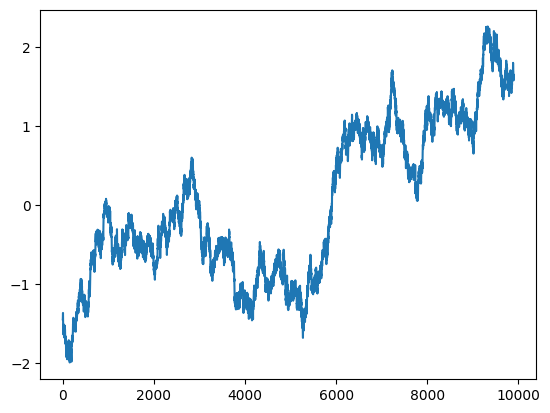

In [35]:
steps = 10000
init_seq = np.array([1, 2, 3])
weights = np.array([0.1001, 0.2, 0.7, 0.1])
noise_func = gaussian_noise
sim_data = ar_data_generator(init_seq, weights, noise_func, steps, normalize=True)
data = sim_data[100:, None]
plt.plot(data[:, 0])
plt.show()

In [ ]:
# models
class FF(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim):
        super(FF, self).__init__()
        self.fc1 = nn.Linear(input_dim*seq_length, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # (batch size x seq length x input dim)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x[:, 0]


class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.output_dim = output_dim
        self.rnn = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.0,
            batch_first=True,
        )
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.rnn(x)[0]
        x = x[:, -1, :]
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x[:, 0]


class TemporalConvolution(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super(TemporalConvolution, self).__init__()
        self.conv1d = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)

    def forward(self, x):
        # Permute the input for 1D convolution
        x = x.permute(1, 2, 0)
        conv_out = self.conv1d(x)
        # Revert the permutation
        conv_out = conv_out.permute(2, 0, 1)
        return conv_out


class Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, seq_len):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, dropout=0.5)
        self.encoder = nn.TransformerEncoder(self.encoder_layers, num_layers)
        self.temporal_conv = TemporalConvolution(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim*seq_len, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        x = self.temporal_conv(x)
        x = x.permute(1, 0, 2)
        encoder_output = self.encoder(x)
        encoder_output = encoder_output.permute(1, 0, 2)
        encoder_output = encoder_output.reshape(encoder_output.shape[0], -1)
        x = self.relu(self.fc1(encoder_output))
        x = self.fc2(x)
        return encoder_output[:, 0]


def perfect_model(x, weights):
    """
    x is in the shape of (batch size x seq length x input dim)
    """
    x = x[:, :, 0]
    res = []
    for b in range(x.shape[0]):
        cur_res = 0
        for i in range(len(weights)-1):
            cur_res += x[b, i] * weights[i]
        res.append(cur_res)
    return torch.tensor(res)

In [4]:
def train_eval(model, init_seq, weights, noise_func):
    learning_rate = 2e-5
    device = torch.device('cuda:0')
    epochs = 200

    steps = 10000
    sim_data = ar_data_generator(init_seq, weights, noise_func, steps, normalize=False)
    data = sim_data[100:, None]
    train_dl, val_dl, test_dl = prepare_ts_ds(data, 3, 0, 2000, 500, 1000, 32)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.L1Loss()

    for _ in tqdm(range(epochs)):
        model.train()
        losses = []
        for batch in train_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            # print(y_pred)
            # print(y)
            loss = loss_fn(y, y_pred)
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1, error_if_nonfinite=True)
            optimizer.step()
            losses.append(loss.detach().cpu().numpy())
        # print(f'loss is {np.mean(losses)}')
        model.eval()
        val_losses = []
        plosses = []
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            # print(y.shape)
            y_pred = model(x)
            # print(y_pred.shape)
            loss = loss_fn(y, y_pred)
            val_losses.append(loss.detach().cpu().numpy())
            py_pred = perfect_model(x, weights).to(device)
            ploss = loss_fn(y, py_pred)
            plosses.append(ploss.detach().cpu().numpy())
        # print(f'val loss is {np.mean(val_losses)}, perfect loss: {np.mean(plosses)}')
    # test
    model.eval()
    tys = []
    pys = []
    perfect_pys = []
    for batch in test_dl:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        py_pred = perfect_model(x, weights).to(device)
        # save
        y_pred = y_pred.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        py_pred = py_pred.detach().cpu().numpy()
        for i in range(len(y)):
            tys.append(y[i])
            pys.append(y_pred[i])
            perfect_pys.append(py_pred[i])
    tys = np.array(tys)
    pys = np.array(pys)    
    return tys, pys


def pickle_save(fname, data):
    with open(fname, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(fname, version5=False):
    if version5:
        with open(fname, 'rb') as handle:
            return pickle5.load(handle)
    with open(fname, 'rb') as handle:
        return pickle.load(handle)

In [ ]:
# Transformer(1, 16, 2, 4, 3)
model_names = ['FF', 'RNN', 'Transformer']
models = [FF(1, 3, 64), RNN(1, 64, 4, 1), Transformer(1, 32, 2, 4, 3)]
init_seq = np.array([1, 2, 3])
weights = np.array([0.1001, 0.2, 0.7, 0.01])
noise_func = gaussian_noise

x_ticks = np.linspace(-10, 5, 20)
noise_factors = [10**x_tick for x_tick in x_ticks]



results = {}
for noise_factor in noise_factors:
    weights[-1] = noise_factor
    tys, pys = train_eval(models[0], init_seq, weights, gaussian_noise)
    results[noise_factor] = (tys, pys)
pickle_save('results/ff_res.pkl', results)

results = {}
for noise_factor in noise_factors:
    weights[-1] = noise_factor
    tys, pys = train_eval(models[1], init_seq, weights, gaussian_noise)
    results[noise_factor] = (tys, pys)
pickle_save('results/rnn_res.pkl', results)

results = {}
for noise_factor in noise_factors:
    weights[-1] = noise_factor
    tys, pys = train_eval(models[2], init_seq, weights, gaussian_noise)
    results[noise_factor] = (tys, pys)
pickle_save('results/tf_res.pkl', results)

In [5]:
def rmse(predictions, targets):
    """
    Root Mean Squared Error
    Args:
        predictions (np.ndarray): Point Predictions of the model
        targets (np.ndarray): Point Targets of the model
    Returns:
        float: RMSE
    """
    return np.sqrt(((predictions - targets) ** 2).mean())


def norm_rmse(predictions, targets):
    """
    Root Mean Squared Error
    Args:
        predictions (np.ndarray): Point Predictions of the model
        targets (np.ndarray): Point Targets of the model
    Returns:
        float: RMSE
    """
    try:
        scale = MinMaxScaler()
        targets = scale.fit_transform(targets[:,None])
        predictions = scale.transform(predictions[:,None])
    finally:
       return np.sqrt(((predictions - targets) ** 2).mean())


def mape(predictions, targets):
    """
    Mean Absolute Percentage Error
    Args:
        predictions (np.ndarray): Predictions of the model
        targets (np.ndarray): Targets of the model
    Returns:
        float: MAPE
    """
    targets[targets==0] = np.nan
    return np.nanmean(np.abs((predictions - targets) / targets)) * 100

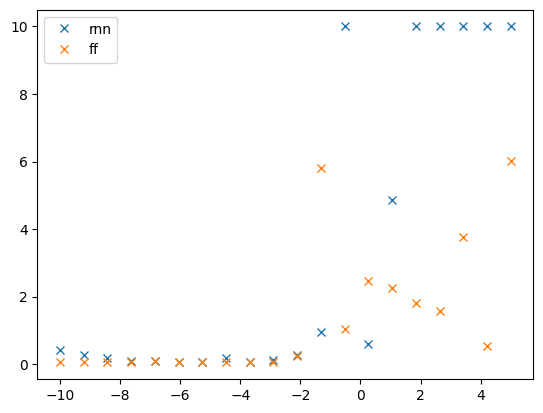

In [32]:
x_ticks = []
threhold = 10

ys1 = []
ff_res = pickle_load('results/rnn_res.pkl')
for key, value in ff_res.items():
    x_ticks.append(np.log10(key))
    tys, pys = value
    cur_y = mape(pys, tys)
    if cur_y > threhold:
        cur_y = threhold
    ys1.append(cur_y)
ff_res = pickle_load('results/ff_res.pkl')
ys2 = []
for key, value in ff_res.items():
    tys, pys = value
    cur_y = mape(pys, tys)
    if cur_y > threhold:
        cur_y = threhold
    ys2.append(cur_y)

plt.plot(x_ticks, ys1, 'x', label='rnn')
plt.plot(x_ticks, ys2, 'x', label='ff')
plt.legend()
plt.show()

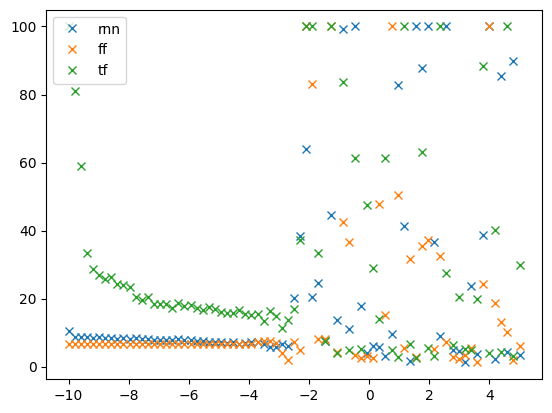

In [30]:
x_ticks = []
threhold = 100

ys1 = []
ff_res = pickle_load('results/norm_rnn_res.pkl')
for key, value in ff_res.items():
    x_ticks.append(np.log10(key))
    tys, pys = value
    cur_y = mape(pys, tys)
    if cur_y > threhold:
        cur_y = threhold
    ys1.append(cur_y)
ff_res = pickle_load('results/norm_ff_res.pkl')
ys2 = []
for key, value in ff_res.items():
    tys, pys = value
    cur_y = mape(pys, tys)
    if cur_y > threhold:
        cur_y = threhold
    ys2.append(cur_y)
ff_res = pickle_load('results/norm_tf_res.pkl')
ys3 = []
for key, value in ff_res.items():
    tys, pys = value
    cur_y = mape(pys, tys)
    if cur_y > threhold:
        cur_y = threhold
    ys3.append(cur_y)

plt.plot(x_ticks, ys1, 'x', label='rnn')
plt.plot(x_ticks, ys2, 'x', label='ff')
plt.plot(x_ticks, ys3, 'x', label='tf')
plt.legend()
plt.show()

-10.0
-9.210526315789474
-8.421052631578947
-7.631578947368421
-6.842105263157895
-6.052631578947368
-5.2631578947368425
-4.473684210526316
-3.6842105263157894
-2.894736842105263
-2.1052631578947363
-1.3157894736842106


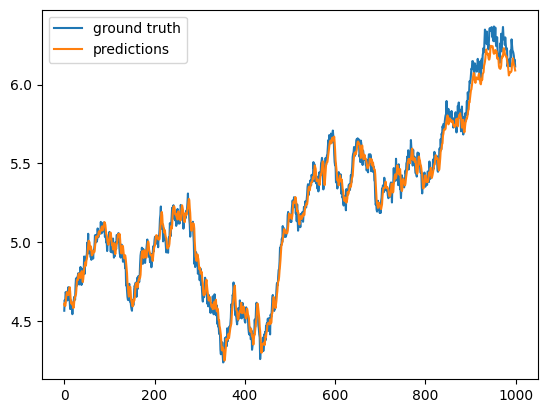

In [21]:
def plot_res(filepath, noise_order):
    ff_res = pickle_load(filepath)
    noise_factor = noise_order
    for key, value in ff_res.items():
        print(np.log10(key))
        if np.abs(np.log10(key) - noise_factor) < 0.5:
            y_true, y_pred = value
            plt.plot(y_true, label='ground truth')
            plt.plot(y_pred, label='predictions')
            plt.legend()
            plt.show()
            break

filenames = ['results/rnn_res.pkl', 'results/ff_res.pkl']
plot_res(filenames[0], -1)